**This Test File is implemented by Jin Ziqi(57854391)**

**This is a Test File to test if the model can work correctly**

It just load the pretrained weight to the model, and implement a dynamic window to upload the test images and get the returned result

In [ ]:
# Install the torchinfo package for showing the network architecture information
!pip install torchinfo -qqq

In [ ]:
# Import the necessary libraries for working with CIFART-10 dataset and PyTorch.
import torch
import torchvision
from torchvision import datasets,transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import nn,optim,no_grad
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from torchinfo import summary

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import pickle
import sys
import time
import math

In [ ]:

# To configure the usage of a GPU (cuda) or MPS (Apple) if either of them is available
has_mps = torch.backends.mps.is_built()
device = "cuda" if torch.cuda.is_available() else "mps" if has_mps else "cpu"
print(f"Python versoin: {sys.version_info.major, sys.version_info.minor, sys.version_info.micro}")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

Python versoin: (3, 10, 12)
PyTorch version: 2.5.1+cu121
Device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 定义通道混洗函数
def channel_shuffle(x, groups=2):
    batch_size, channels, width, height = x.shape
    group_channels = channels // groups
    x = x.view(batch_size, groups, group_channels, width, height)
    x = torch.transpose(x, 1, 2).contiguous()
    x = x.view(batch_size, -1, width, height)
    return x

# 定义1x1卷积 + BatchNorm + ReLU
def conv_1x1_bn(in_channels, out_channels, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 1, stride, 0, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

# 定义3x3卷积 + BatchNorm + ReLU
def conv_bn(in_channels, out_channels, stride=2):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

# 定义 ShuffleBlock
class ShuffleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ShuffleBlock, self).__init__()
        self.downsample = downsample
        half_channels = out_channels // 2
        if downsample:
            self.branch1 = nn.Sequential(
                nn.Conv2d(in_channels, in_channels, 3, 2, 1, groups=in_channels, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.Conv2d(in_channels, half_channels, 1, 1, 0, bias=False),
                nn.BatchNorm2d(half_channels),
                nn.ReLU(inplace=True)
            )
            self.branch2 = nn.Sequential(
                nn.Conv2d(in_channels, half_channels, 1, 1, 0, bias=False),
                nn.BatchNorm2d(half_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(half_channels, half_channels, 3, 2, 1, groups=half_channels, bias=False),
                nn.BatchNorm2d(half_channels),
                nn.Conv2d(half_channels, half_channels, 1, 1, 0, bias=False),
                nn.BatchNorm2d(half_channels),
                nn.ReLU(inplace=True)
            )
        else:
            assert in_channels == out_channels
            self.branch2 = nn.Sequential(
                nn.Conv2d(half_channels, half_channels, 1, 1, 0, bias=False),
                nn.BatchNorm2d(half_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(half_channels, half_channels, 3, 1, 1, groups=half_channels, bias=False),
                nn.BatchNorm2d(half_channels),
                nn.Conv2d(half_channels, half_channels, 1, 1, 0, bias=False),
                nn.BatchNorm2d(half_channels),
                nn.ReLU(inplace=True)
            )

    def forward(self, x):
        if self.downsample:
            out = torch.cat((self.branch1(x), self.branch2(x)), 1)
        else:
            channels = x.shape[1]
            half = channels // 2
            x1 = x[:, :half, :, :]
            x2 = x[:, half:, :, :]
            out = torch.cat((x1, self.branch2(x2)), 1)
        return channel_shuffle(out, 2)

class ShuffleNet2(nn.Module):
    def __init__(self, num_classe, input_size=224, net_type=2, dropout_rate=0.5):
        super(ShuffleNet2, self).__init__()
        assert input_size % 32 == 0

        # 增加每个 `net_type` 对应的通道数，以增加复杂度
        self.stage_repeat_num = [6, 10, 6]  # 增加重复次数
        if net_type == 0.5:
            self.out_channels = [3, 24, 48, 96, 192, 1024]
        elif net_type == 1:
            self.out_channels = [3, 24, 116, 232, 464, 1024]
        elif net_type == 1.5:
            self.out_channels = [3, 24, 176, 352, 704, 1024]
        elif net_type == 2:
            self.out_channels = [3, 24, 244, 488, 976, 2048]
        else:
            raise ValueError("net_type must be one of 0.5, 1, 1.5, or 2")

        # 第一个卷积层
        self.conv1 = nn.Conv2d(3, self.out_channels[1], 3, 2, 1)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        in_channels = self.out_channels[1]

        # 添加更多的 ShuffleBlock 以增加复杂度
        self.stages = []
        for stage_idx in range(len(self.stage_repeat_num)):
            out_channels = self.out_channels[2 + stage_idx]
            repeat_num = self.stage_repeat_num[stage_idx]
            for i in range(repeat_num):
                downsample = (i == 0)
                self.stages.append(ShuffleBlock(in_channels, out_channels, downsample=downsample))
                in_channels = out_channels
        self.stages = nn.Sequential(*self.stages)

        # 在 conv5 前增加一个额外的卷积层
        in_channels = self.out_channels[-2]
        self.extra_conv = conv_bn(in_channels, in_channels * 2, stride=1)
        in_channels *= 2
        out_channels = self.out_channels[-1]

        # 最终卷积层
        self.conv5 = conv_1x1_bn(in_channels, out_channels, 1)
        self.g_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.dropout = nn.Dropout(dropout_rate)  # 添加 Dropout 层
        self.fc = nn.Linear(out_channels, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.stages(x)
        x = self.extra_conv(x)  # 经过额外的卷积层
        x = self.conv5(x)
        x = self.g_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/My models/saved_model.pth'

# Step 3: 加载模型
# 确保你使用的模型架构和保存模型时的一致
model = torch.load(model_path)
model.eval()  # 设置模型为评估模式

print("Model loaded successfully from Google Drive!")

<ipython-input-25-829f631764ab>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


Model loaded successfully from Google Drive!


In [ ]:

train_path = '/content/drive/MyDrive/Colab Notebooks/trainset'
test_path = '/content/drive/MyDrive/Colab Notebooks/testset'

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision import datasets, transforms

# 下载并安装中文字体
!apt-get -qq install -y fonts-noto-cjk

import matplotlib.font_manager as fm

# 查找可用的 Noto 字体
font_dirs = fm.findSystemFonts(fontpaths=None)
print("Available fonts:", font_dirs)

# 设置使用的中文字体
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"  # 正确的字体路径
font_prop = fm.FontProperties(fname=font_path)

Available fonts: ['/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf', '/usr/share/fonts/opentype/noto/NotoSerifCJK-Bold.ttc', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf', '/usr/share/fonts/opentype/noto/NotoSerifCJK-Regular.ttc', '/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf', '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc', '/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf', '/usr/share/fonts/truetype/humor-sans/Humor-Sans.tt

In [ ]:
from torchvision import transforms

# 定义训练集的 transforms，使用数据增强技术
train_transform = transforms.Compose([
    transforms.Resize(256),                             # 调整图像大小，适当放大原始图像
    transforms.RandomResizedCrop(224),  # 随机裁剪，保留60%-100%的区域并缩放到224x224
    transforms.RandomHorizontalFlip(p=0.5),             # 以0.5的概率水平翻转
    transforms.RandomVerticalFlip(p=0.5),               # 以0.5的概率垂直翻转
    #transforms.RandomRotation(degrees=10),              # 随机旋转最多45度
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # 更强的亮度、对比度、饱和度、色调调整
    #transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=20),  # 更强的仿射变换，包括缩放和剪切
    #transforms.RandomPerspective(distortion_scale=0.5, p=0.5),  # 随机透视变换，增强图像的变形
    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  # 随机擦除，覆盖一部分图像区域
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 定义测试集的 transforms，不使用数据增强，仅进行预处理
test_transform = transforms.Compose([
    transforms.Resize(256),  # 将图像缩放到 256 像素
    transforms.CenterCrop(224),  # 中心裁剪为 224x224 大小
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])




# 加载解压后的数据集
train_set = datasets.ImageFolder(root=train_path, transform=train_transform)
test_set = datasets.ImageFolder(root=test_path, transform=test_transform)

# 创建数据加载器
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


# Define the classes if they are known
classes = [
    '云芝', '冬菇', '冬虫夏草','出血齿菌', '变绿红菇', '大青褶伞', '大鹿花菌', '宽鳞多孔菌',
    '尾花笼头菌', '干巴菌','恶魔雪茄蘑菇', '杏鮑菇', '欧洲黑木耳','毒丝盖伞', '毒蕈', '毒蝇伞', '毛头鬼伞',
    '灵芝','牛舌菌', '狭头小菇', '猴头菇', '硫黄菌', '竹荪', '粉红枝瑚菌', '粪生黑蛋巢菌',
    '紫蜡蘑','綠蓋粉孢牛肝菌', '红笼头菌', '红紫柄小菇' ,'细褐鳞蘑菇', '羊肚菌', '美味牛肝菌','蓝绿乳菇', '裂褶菌',
    '赭红拟口蘑', '金黃鵝膏菌','鳞柄白鹅膏','鹿蕊', '黄裙竹荪', '黑松露'
]


# Check dataset loading
print("Number of training samples:", len(train_set))
print("Number of test samples:", len(test_set))
print("Classes:", classes)
print("Class to index mapping:", train_set.class_to_idx)
print(len(classes))




Number of training samples: 7548
Number of test samples: 1367
Classes: ['云芝', '冬菇', '冬虫夏草', '出血齿菌', '变绿红菇', '大青褶伞', '大鹿花菌', '宽鳞多孔菌', '尾花笼头菌', '干巴菌', '恶魔雪茄蘑菇', '杏鮑菇', '欧洲黑木耳', '毒丝盖伞', '毒蕈', '毒蝇伞', '毛头鬼伞', '灵芝', '牛舌菌', '狭头小菇', '猴头菇', '硫黄菌', '竹荪', '粉红枝瑚菌', '粪生黑蛋巢菌', '紫蜡蘑', '綠蓋粉孢牛肝菌', '红笼头菌', '红紫柄小菇', '细褐鳞蘑菇', '羊肚菌', '美味牛肝菌', '蓝绿乳菇', '裂褶菌', '赭红拟口蘑', '金黃鵝膏菌', '鳞柄白鹅膏', '鹿蕊', '黄裙竹荪', '黑松露']
Class to index mapping: {'云芝': 0, '冬菇': 1, '冬虫夏草': 2, '出血齿菌': 3, '变绿红菇': 4, '大青褶伞': 5, '大鹿花菌': 6, '宽鳞多孔菌': 7, '尾花笼头菌': 8, '干巴菌': 9, '恶魔雪茄蘑菇': 10, '杏鮑菇': 11, '欧洲黑木耳': 12, '毒丝盖伞': 13, '毒蕈': 14, '毒蝇伞': 15, '毛头鬼伞': 16, '灵芝': 17, '牛舌菌': 18, '狭头小菇': 19, '猴头菇': 20, '硫黄菌': 21, '竹荪': 22, '粉红枝瑚菌': 23, '粪生黑蛋巢菌': 24, '紫蜡蘑': 25, '綠蓋粉孢牛肝菌': 26, '红笼头菌': 27, '红紫柄小菇': 28, '细褐鳞蘑菇': 29, '羊肚菌': 30, '美味牛肝菌': 31, '蓝绿乳菇': 32, '裂褶菌': 33, '赭红拟口蘑': 34, '金黃鵝膏菌': 35, '鳞柄白鹅膏': 36, '鹿蕊': 37, '黄裙竹荪': 38, '黑松露': 39}
40


40


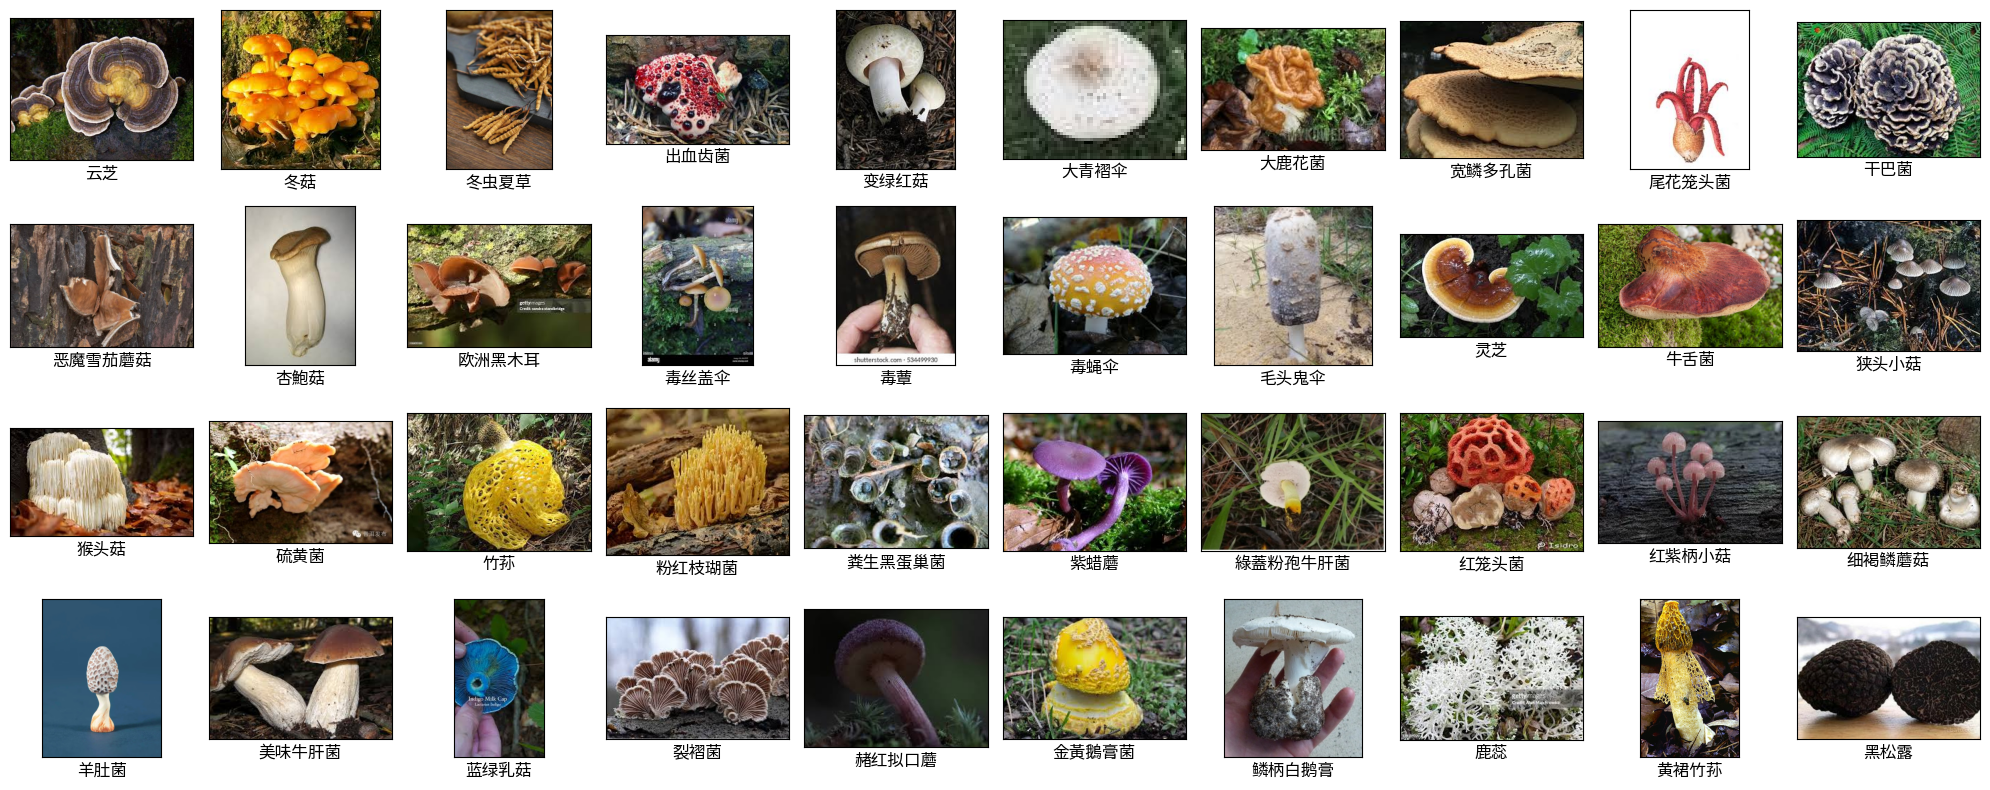

In [ ]:
# 获取类别数
num_classes = len(classes)
classes = train_set.classes
print(len(train_set.classes))

# 确保 classes 和 train_set.class_to_idx 对应
class_idx_to_chinese = {v: classes[v] for v in range(len(classes))}

# 每个类别选择一张示例图像
sample_images = []
for label in range(len(classes)):
    # 找到第一个属于当前类别的图像
    for path, target in train_set.imgs:
        if target == label:
            img = Image.open(path).convert("RGB")  # 转换为RGB
            sample_images.append((img, class_idx_to_chinese[label]))  # 用中文名作为标签
            break

# 设置显示网格
fig, axes = plt.subplots(4, 10, figsize=(20, 8))
i = 0
for row in axes:
    for axis in row:
        axis.set_xticks([])
        axis.set_yticks([])
        if i < len(sample_images):
            img, label = sample_images[i]
            axis.set_xlabel(label, fontsize=12, fontproperties=font_prop)  # 中文标签
            axis.imshow(img)
        else:
            axis.axis('off')  # 如果样本不足，关闭多余的子图框
        i += 1

plt.tight_layout()
plt.show()

In [ ]:
criterion = nn.CrossEntropyLoss()

pred_vec = []
label_vec = []
correct = 0
test_loss = 0.0
avg_test_loss = 0.0

model.to(device)
model.eval()
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = model(batch)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        test_loss += loss.item()
        pred_vec.extend(predicted.cpu().numpy())  # Convert tensor to numpy array
        label_vec.extend(labels.cpu().numpy())  # Convert tensor to numpy array

    avg_test_loss = test_loss / len(test_set)

pred_vec = np.array(pred_vec)
label_vec = np.array(label_vec)


In [ ]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(label_vec, pred_vec)
# Convert confusion matrix to pandas DataFrame
labels = np.unique(label_vec)
confusion_df = pd.DataFrame(confusion_mat, index=classes, columns=classes)
print("Confusion Matrix")
confusion_df

Confusion Matrix


云芝  冬菇  冬虫夏草  出血齿菌  变绿红菇  大青褶伞  大鹿花菌  宽鳞多孔菌  尾花笼头菌  干巴菌  ...  羊肚菌  \
云芝       27   0     0     0     0     0     0      0      0    2  ...    1   
冬菇        0  24     2     0     0     0     0      0      0    0  ...    0   
冬虫夏草      0   0    53     0     0     0     1      0      0    0  ...    0   
出血齿菌      0   0     0    30     0     0     0      0      0    0  ...    0   
变绿红菇      0   0     0     0    29     0     0      0      0    0  ...    0   
大青褶伞      1   0     0     0     0    24     0      0      0    0  ...    0   
大鹿花菌      0   0     0     0     0     0    30      0      0    0  ...    0   
宽鳞多孔菌     0   0     0     0     0     0     0     22      0    0  ...    0   
尾花笼头菌     0   0     0     0     0     0     0      0     26    0  ...    0   
干巴菌       0   0     0     0     0     0     0      0      0   29  ...    0   
恶魔雪茄蘑菇    0   0     0     0     0     0     0      0      2    0  ...    0   
杏鮑菇       0   0     0     0     0     1     0      0      0    0  ...    0   
欧洲黑木耳     2   3     0     0     0     0     0      0      0    0  ...    0   
毒丝盖伞      0   6     0     0     0     0     0      0      0    0  ...    0   
毒蕈        0   0     0     0     0     0     0      1      0    0  ...    0   
毒蝇伞       0   0     0     0     0     0     0      0      0    0  ...    0   
毛头鬼伞      0   0     0     0     0     0     0      0      0    0  ...    0   
灵芝        0   0     0     0     0     0     0      0      0    0  ...    0   
牛舌菌       0   0     0     0     0     0     0      1      0    0  ...    0   
狭头小菇      0   0     0     0     0     0     0      0      0    0  ...    0   
猴头菇       0   0     0     0     0     0     0      0      0    0  ...    0   
硫黄菌       0   0     0     0     0     0     0      0      0    0  ...    0   
竹荪        0   0     0     0     0     0     0      0      0    0  ...    0   
粉红枝瑚菌     0   0     1     0     0     0     0      0      0    0  ...    0   
粪生黑蛋巢菌    0   0     0     0     0     0     0      0      0    2  ...    0   
紫蜡蘑       0   0     0     0     0     0     0      0      0    0  ...    0   
綠蓋粉孢牛肝菌   0   0     0     0     0     0     0      0      0    0  ...    0   
红笼头菌      0   0     0     0     0     0     0      0      0    0  ...    0   
红紫柄小菇     0   0     0     0     0     1     0      0      0    0  ...    0   
细褐鳞蘑菇     0   0     0     0     0     2     0      1      0    0  ...    0   
羊肚菌       0   0     0     0     0     0     0      0      0    0  ...   32   
美味牛肝菌     0   0     0     0     0     0     0      0      0    1  ...    1   
蓝绿乳菇      0   0     0     0     1     0     0      0      0    0  ...    0   
裂褶菌       1   0     0     0     0     0     0      0      0    0  ...    0   
赭红拟口蘑     0   0     0     0     0     0     0      0      0    0  ...    0   
金黃鵝膏菌     0   0     0     0     0     0     0      0      0    0  ...    0   
鳞柄白鹅膏     0   0     0     0     1     0     0      0      0    0  ...    0   
鹿蕊        0   0     0     0     0     0     0      0      0    1  ...    0   
黄裙竹荪      0   0     0     0     0     0     0      1      0    0  ...    0   
黑松露       0   0     0     0     0     0     0      0      0    0  ...    0   

         美味牛肝菌  蓝绿乳菇  裂褶菌  赭红拟口蘑  金黃鵝膏菌  鳞柄白鹅膏  鹿蕊  黄裙竹荪  黑松露  
云芝           0     0    0      0      0      0   0     0    0  
冬菇           0     0    1      0      0      0   0     0    0  
冬虫夏草         0     0    0      0      0      0   0     0    0  
出血齿菌         0     0    0      0      0      0   0     0    0  
变绿红菇         0     0    0      0      0      0   0     0    0  
大青褶伞         0     0    0      0      0      1   0     0    0  
大鹿花菌         0     0    0      0      0      0   0     0    0  
宽鳞多孔菌        0     0    1      0      0      0   0     0    0  
尾花笼头菌        0     0    0      0      0      0   0     1    0  
干巴菌          0     1    0      0      0      0   0     0    0  
恶魔雪茄蘑菇       0     0    0      0      0      0   0     0    0  
杏鮑菇          2     1    0      0      0   

In [ ]:

# Create a report to show the f1-score, precision, recall
from sklearn.metrics import classification_report

report = pd.DataFrame.from_dict(classification_report(pred_vec,label_vec,output_dict=True)).T
report['Label']=[classes[int(x)] if x.isdigit() else " " for x in report.index]
report=report[['Label','f1-score','precision','recall','support']]
report

Label  f1-score  precision    recall      support
0                  云芝  0.885246   0.900000  0.870968    31.000000
1                  冬菇  0.705882   0.685714  0.727273    33.000000
2                冬虫夏草  0.954955   0.963636  0.946429    56.000000
3                出血齿菌  1.000000   1.000000  1.000000    30.000000
4                变绿红菇  0.950820   0.966667  0.935484    31.000000
5                大青褶伞  0.827586   0.800000  0.857143    28.000000
6                大鹿花菌  0.983607   1.000000  0.967742    31.000000
7               宽鳞多孔菌  0.862745   0.880000  0.846154    26.000000
8               尾花笼头菌  0.896552   0.866667  0.928571    28.000000
9                 干巴菌  0.892308   0.966667  0.828571    35.000000
10             恶魔雪茄蘑菇  0.869565   0.769231  1.000000    20.000000
11                杏鮑菇  0.896552   0.866667  0.928571    28.000000
12              欧洲黑木耳  0.862069   0.833333  0.892857    28.000000
13               毒丝盖伞  0.893617   0.875000  0.913043   115.000000
14                 毒蕈  0.793651   0.833333  0.757576    33.000000
15                毒蝇伞  0.967742   1.000000  0.937500    32.000000
16               毛头鬼伞  0.935484   0.966667  0.906250    32.000000
17                 灵芝  0.771429   0.675000  0.900000    30.000000
18                牛舌菌  0.718750   0.766667  0.676471    34.000000
19               狭头小菇  0.909091   0.937500  0.882353    34.000000
20                猴头菇  0.875000   0.933333  0.823529    34.000000
21                硫黄菌  0.950820   0.966667  0.935484    31.000000
22                 竹荪  0.806452   0.833333  0.781250    32.000000
23              粉红枝瑚菌  0.971429   0.971429  0.971429    35.000000
24             粪生黑蛋巢菌  0.925373   0.885714  0.968750    32.000000
25                紫蜡蘑  0.927536   1.000000  0.864865    37.000000
26            綠蓋粉孢牛肝菌  0.720000   0.750000  0.692308    26.000000
27               红笼头菌  0.952381   1.000000  0.909091    33.000000
28              红紫柄小菇  0.903226   0.848485  0.965517    58.000000
29              细褐鳞蘑菇  0.724138   0.700000  0.750000    28.000000
30                羊肚菌  0.955224   0.969697  0.941176    34.000000
31              美味牛肝菌  0.774194   0.800000  0.750000    32.000000
32               蓝绿乳菇  0.950820   0.966667  0.935484    31.000000
33                裂褶菌  0.915254   0.900000  0.931034    29.000000
34              赭红拟口蘑  0.714286   0.689655  0.740741    27.000000
35              金黃鵝膏菌  0.915254   0.900000  0.931034    29.000000
36              鳞柄白鹅膏  0.806452   0.833333  0.781250    32.000000
37                 鹿蕊  0.950820   0.966667  0.935484    31.000000
38               黄裙竹荪  0.847458   0.833333  0.862069    29.000000
39                黑松露  0.967742   1.000000  0.937500    32.000000
accuracy               0.882224   0.882224  0.882224     0.882224
macro avg              0.878288   0.882527  0.877774  1367.000000
weighted avg           0.882808   0.886798  0.882224  1367.000000

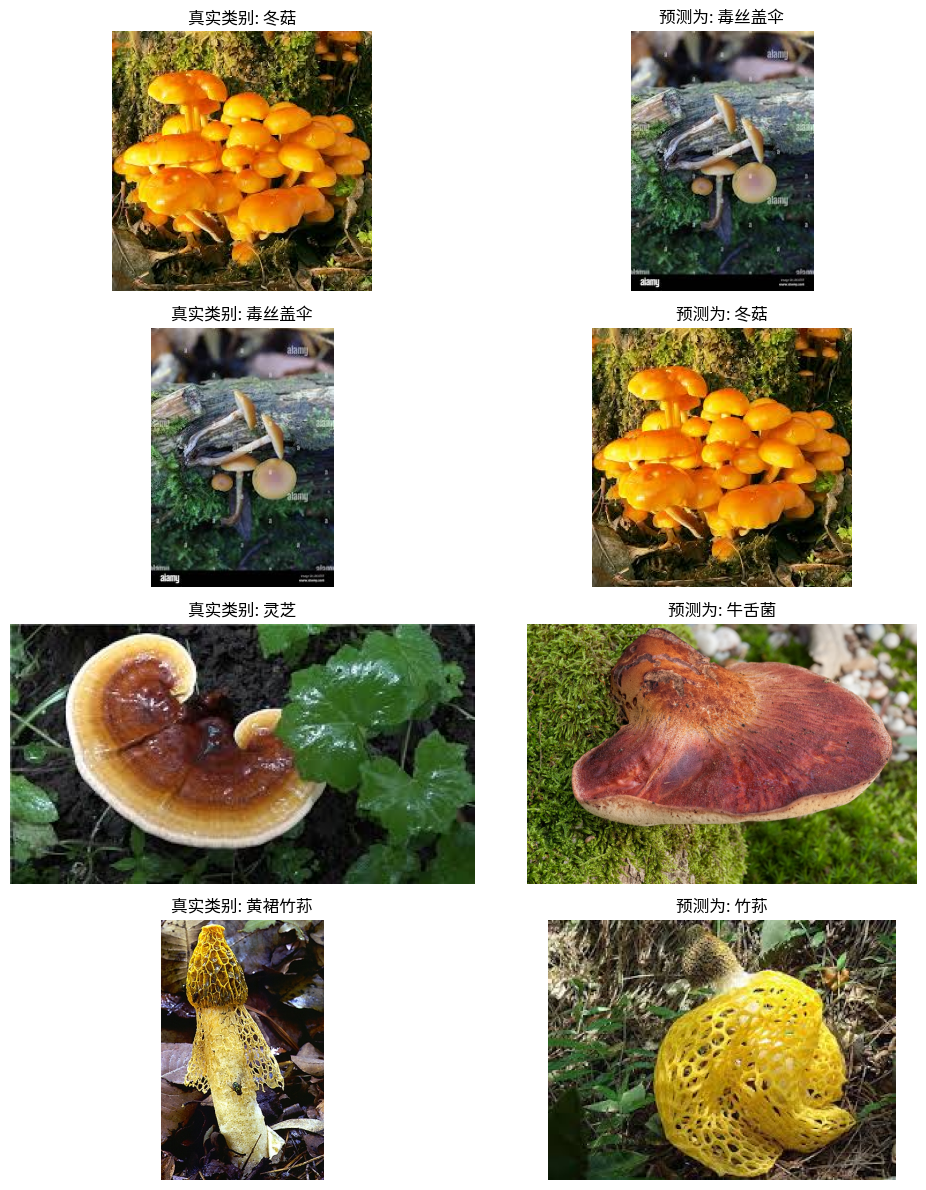

In [ ]:

# 使用提供的蘑菇类别名称列表
classes = [
    '云芝', '冬菇', '冬虫夏草','出血齿菌', '变绿红菇', '大青褶伞', '大鹿花菌', '宽鳞多孔菌',
    '尾花笼头菌', '干巴菌','恶魔雪茄蘑菇', '杏鮑菇', '欧洲黑木耳','毒丝盖伞', '毒蕈', '毒蝇伞', '毛头鬼伞',
    '灵芝','牛舌菌', '狭头小菇', '猴头菇', '硫黄菌', '竹荪', '粉红枝瑚菌', '粪生黑蛋巢菌',
    '紫蜡蘑','綠蓋粉孢牛肝菌', '红笼头菌', '红紫柄小菇' ,'细褐鳞蘑菇', '羊肚菌', '美味牛肝菌','蓝绿乳菇', '裂褶菌',
    '赭红拟口蘑', '金黃鵝膏菌','鳞柄白鹅膏','鹿蕊', '黄裙竹荪', '黑松露'
]

# 生成混淆矩阵
confusion_mat = confusion_matrix(label_vec, pred_vec)
labels = np.unique(label_vec)

# 转换为 DataFrame
confusion_df = pd.DataFrame(confusion_mat, index=labels, columns=labels)

# 找到所有易混淆的类别对
threshold = 3  # 误分类次数阈值，可调小以增加混淆对数
confused_pairs = []
for i in range(len(labels)):
    for j in range(len(labels)):
        if i != j and confusion_df.iloc[i, j] > threshold:
            confused_pairs.append((labels[i], labels[j], confusion_df.iloc[i, j]))

# 从 train_set 中找到对应类别的图像样本
sample_images = []
for label in range(len(classes)):
    for path, target in train_set.imgs:
        if target == label:
            img = Image.open(path).convert("RGB")  # 转换为 RGB 格式
            sample_images.append((img, classes[label]))  # 用中文名作为标签
            break

# 检查是否有符合条件的混淆类别对
num_pairs = len(confused_pairs)

if num_pairs > 0:
    # 处理单个配对的情况
    if num_pairs == 1:
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        axes = np.array([axes])  # 将 axes 转换为二维数组，方便统一处理
    else:
        fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 3 * num_pairs))

    for i, (label1, label2, _) in enumerate(confused_pairs):
        # 获取每个类别的图像和标签
        img1, label_name1 = sample_images[label1]
        img2, label_name2 = sample_images[label2]

        # 左侧：真实类别
        axes[i, 0].imshow(img1)
        axes[i, 0].set_title(f"真实类别: {label_name1}", fontproperties=font_prop, fontsize=12)
        axes[i, 0].axis('off')

        # 右侧：预测类别
        axes[i, 1].imshow(img2)
        axes[i, 1].set_title(f"预测为: {label_name2}", fontproperties=font_prop, fontsize=12)
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("没有符合条件的混淆类别对。")


In [ ]:
print(confused_pairs)

[(1, 13, 4), (13, 1, 6), (17, 18, 8), (38, 22, 4)]


FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Files uploaded: ['images (1).jpg']
Processing image 1 of 1


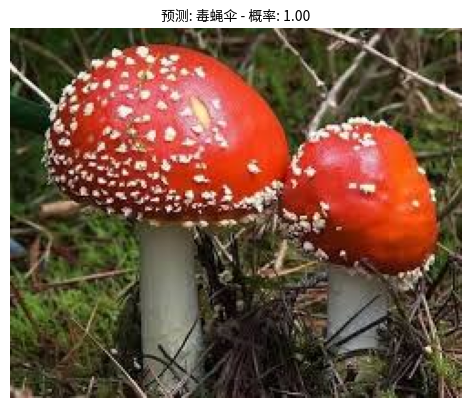

Files uploaded: ['images (1).jpg']
Processing image 1 of 1


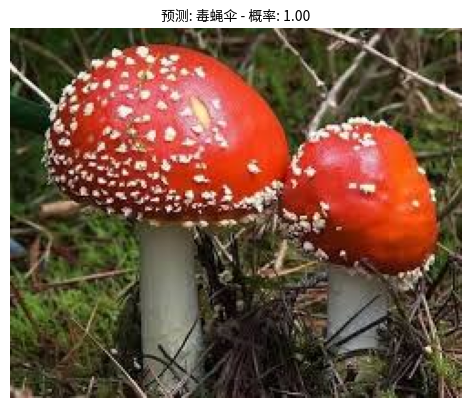

Files uploaded: ['10078.jpeg']
Processing image 1 of 1
This mushroom is in the error prediction pairs.


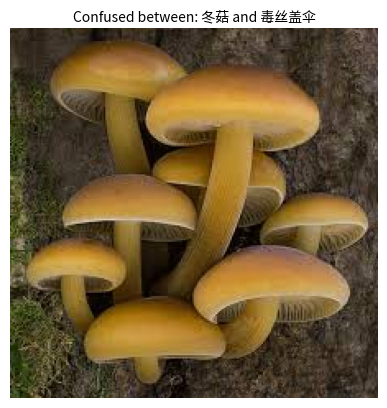

Files uploaded: ['10078.jpeg']
Processing image 1 of 1
This mushroom is in the error prediction pairs.


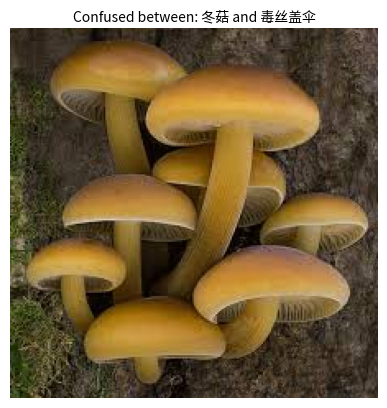

In [ ]:
import torch
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
from io import BytesIO
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Load Noto font for displaying Chinese characters
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
noto_font = fm.FontProperties(fname=font_path)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Image preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Mushroom class names in Chinese
classes = [
    '云芝', '冬菇', '冬虫夏草', '出血齿菌', '变绿红菇', '大青褶伞', '大鹿花菌', '宽鳞多孔菌',
    '尾花笼头菌', '干巴菌', '恶魔雪茄蘑菇', '杏鮑菇', '欧洲黑木耳', '毒丝盖伞', '毒蕈', '毒蝇伞', '毛头鬼伞',
    '灵芝', '牛舌菌', '狭头小菇', '猴头菇', '硫黄菌', '竹荪', '粉红枝瑚菌', '粪生黑蛋巢菌',
    '紫蜡蘑', '綠蓋粉孢牛肝菌', '红笼头菌', '红紫柄小菇', '细褐鳞蘑菇', '羊肚菌', '美味牛肝菌', '蓝绿乳菇', '裂褶菌',
    '赭红拟口蘑', '金黃鵝膏菌', '鳞柄白鹅膏', '鹿蕊', '黄裙竹荪', '黑松露'
]

# Ensure the model's output matches the length of the classes list
if model.fc.out_features != len(classes):
    raise ValueError("The number of model output classes does not match the length of the classes list.")

# Define the classes for additional error message
error_classes = {'冬菇', '毒丝盖伞', '牛舌菌', '灵芝', '欧洲黑木耳', '红紫柄小菇', '狭头小菇'}

# Generate confusion pairs (using pre-calculated confusion matrix)
threshold = 3  # Adjust this as needed
confused_pairs = []
for i in range(len(labels)):
    for j in range(len(labels)):
        if i != j and confusion_df.iloc[i, j] > threshold:
            confused_pairs.append((classes[labels[i]], classes[labels[j]]))

# Prediction function
def predict_image(image_data, confused_pairs):
    image = Image.open(BytesIO(image_data)).convert("RGB")
    input_image = preprocess(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_image)
        probabilities = torch.nn.functional.softmax(output, dim=1).squeeze(0)  # Convert to 1D tensor

        # Get the top prediction
        top_prob, top_index = probabilities.max(0)
        top_class = classes[top_index]

        # Check if the prediction is in the confused pairs
        for pair in confused_pairs:
            if top_class in pair:
                other_class = pair[1] if pair[0] == top_class else pair[0]
                other_index = classes.index(other_class)
                other_prob = probabilities[other_index].item()
                plt.title(
                    f"Confused between: {pair[0]} and {pair[1]}",
                    fontproperties=noto_font
                )
                break
        else:
            if top_prob < 0.6:  # Confidence threshold
                plt.title("无法识别", fontproperties=noto_font)
            else:
                plt.title(
                    f"预测: {top_class} - 概率: {top_prob:.2f}",
                    fontproperties=noto_font
                )

        # Additional error message for specific classes
        if top_class in error_classes:
            print("This mushroom is in the error prediction pairs.")

    plt.imshow(image)
    plt.axis("off")
    plt.show()

# File upload widget allowing multiple files
upload_widget = widgets.FileUpload(accept='image/*', multiple=True)

def on_upload_change(change):
    if upload_widget.value:
        print("Files uploaded:", list(upload_widget.value.keys()))  # Confirm uploaded file names
        for i, uploaded_file in enumerate(upload_widget.value.values()):
            image_data = uploaded_file['content']
            print(f"Processing image {i+1} of {len(upload_widget.value)}")
            predict_image(image_data, confused_pairs)

        # Clear uploaded files
        upload_widget.value.clear()  # Clear widget value
        upload_widget._counter = 0  # Reset counter

# Set file upload event
upload_widget.observe(on_upload_change, names='value')

# Display upload widget
display(upload_widget)
